## Análise de Sentimentos com Transformers

#### Contexto do Problema
O problema em questão trata-se de classificação de textos. A tarefa consiste em analisar um conjunto de resenhas de livros e prever se a resenha é positiva ou negativa, baseado no conteúdo textual dessas resenhas. Este tipo de problema é típico em sistemas de recomendação, como os utilizados por plataformas como Amazon, Goodreads ou Google Play Books, que precisam identificar automaticamente a satisfação do cliente com base em suas avaliações.

O objetivo do modelo é atribuir uma classe (positiva ou negativa) a cada resenha, usando o conteúdo textual como único atributo. A modelagem de tal problema envolve o uso de técnicas de Processamento de Linguagem Natural (PLN), como a transformação do texto em uma forma que possa ser lida por um modelo de aprendizado de máquina. Para isso, utilizamos vetores de palavras e abordagens como TF-IDF (Term Frequency - Inverse Document Frequency) para extrair as características mais relevantes de cada resenha.

O sucesso deste tipo de tarefa tem aplicações amplas, desde a filtragem de conteúdo até a recomendação personalizada e a análise de sentimentos, onde a precisão do modelo é importante para garantir a fidelidade das análises geradas a partir das resenhas dos usuários.

#### Descrição do Conjunto de Dados: Amazon Polarity
O conjunto de dados Amazon Polarity é uma coleção de resenhas de produtos extraídas de comentários de usuários na Amazon, com o objetivo de realizar a análise de sentimentos. O conjunto contém textos de resenhas que foram classificados como positivos ou negativos com base na opinião expressa pelo usuário. Cada resenha está rotulada com um valor binário: 0 para resenhas negativas e 1 para resenhas positivas.

O conjunto de dados é um recurso muito utilizado em tarefas de classificação de sentimentos e análise de texto, e é ideal para treinar e testar modelos de aprendizado de máquina que buscam identificar automaticamente se uma opinião expressa em uma resenha é favorável ou desfavorável. Com isso, o modelo pode ser utilizado para prever a polaridade de novos comentários ou resenhas.

#### Características do Conjunto de Dados:
##### Tamanho: O conjunto de dados é composto por milhares de resenhas, com rótulos binários indicando se a resenha é positiva (1) ou negativa (0).

##### Texto da Resenha: Cada amostra contém um texto de resenha escrito por um usuário da Amazon. O conteúdo dessas resenhas varia muito em termos de comprimento e tópicos, pois os produtos abrangem uma ampla gama de categorias, como eletrônicos, roupas, acessórios, livros, e muito mais.

##### Polaridade: A principal característica é a polaridade da resenha, onde o modelo precisa prever se a opinião do usuário é positiva ou negativa com base no conteúdo da resenha.

##### Aplicações:
Análise de Sentimentos: O principal objetivo desse conjunto de dados é classificar as opiniões dos consumidores de maneira automática, sem necessidade de leitura manual de cada resenha.
Sistemas de Recomendação: Compreender a opinião dos consumidores sobre determinados produtos pode ser usado para ajustar e melhorar sistemas de recomendação em plataformas de e-commerce.
Análise de Feedback: A análise automática das resenhas pode proporcionar insights valiosos para empresas, permitindo-lhes entender melhor a satisfação do cliente e identificar áreas de melhoria nos produtos.

Os modelos utilizados nesse estudo foram então treinados para prever a classe da resenha, e os seguintes algoritmos foram avaliados no conjunto de dados:

##### Regressão Logística

##### Máquina de Vetores de Suporte (SVM)

##### XGBoost

##### Random Forest

Os resultados de cada modelo foram avaliados com métricas como acurácia, precisão, recall e f1-score e curva AUC para garantir uma análise mais equilibrada, considerando não apenas a taxa de acertos, mas também a performance do modelo nas classes positivas e negativas.

#### Importando dataset da Amazon: Amazon Polarity

In [1]:
# from datasets import load_dataset

# dataset = load_dataset("amazon_polarity")

#### Converter para pandas DataFrame

In [2]:
# import pandas as pd

# df = pd.DataFrame(dataset["train"])

#### Verificar a distribuição das classes

In [3]:
# class_counts = df['label'].value_counts()
# class_counts

#### Obtendo uma amostra dos dados balanceado

In [4]:
# # Balancear para 10k dados, pegando 5k de cada classe
# df_balanced = pd.concat([
#     df[df['label'] == 0].sample(n=5000, random_state=42),  # Classe negativa
#     df[df['label'] == 1].sample(n=5000, random_state=42)   # Classe positiva
# ])

# # Selecionar as primeiras 10k amostras balanceadas
# df_balanced = df_balanced.sample(n=10000, random_state=42)

# #Salvando em um arquivo do tipo 'sample_amazon_polarity.csv'
# df_balanced.to_csv('../data/processed/sample_amazon_polarity.csv', index=False)

#### Lendo a amostra que criamos no salva na pasta processed

In [5]:
import pandas as pd

df_samples = pd.read_csv('../data/processed/sample_amazon_polarity.csv')
df_samples.head()

,label,title,content
0,1,Road to getting things done,I am a great believer in valueing employees an...
1,0,The Weight Loss Cure,This would be a good book. Good Ideas if every...
2,0,Royal Velvet Pillows,These pillows were over rated and the descript...
3,0,Great Book For Kiddies,Robert Sawyer's books have featured an assortm...
4,0,Digimortal,"You know, Fear Factory used to be my favorite ..."


#### Verificando quantidade de amostras, quantidade de colunas e quantidade de classes

Aqui temos uma amostra de 10 mil observações, três colunas: label, title e content duas classes [0, 1].

In [6]:
df_samples.shape

(10000, 3)

In [7]:
df_samples.label.unique()

array([1, 0])

#### Análise Exploratória dos dados

Aqui realizamos alguns tratamentos nos dados para o treinamento dos modelos

##### Função para limpeza dos dados

In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Baixando o conjunto de stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Inicializando o lemmatizer
lemmatizer = WordNetLemmatizer()

# Função para limpar o texto
def clean_text(text):
    # 1. Remover links e emails
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)

    # 2. Remover caracteres especiais e números
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # 3. Converter o texto para minúsculas
    text = text.lower()

    # 4. Tokenização (separar em palavras)
    words = nltk.word_tokenize(text)

    # 5. Remover stopwords
    stop_words = set(stopwords.words('english'))  # Para inglês. Para outro idioma, substitua aqui.
    words = [word for word in words if word not in stop_words]

    # 6. Lemmatização
    words = [lemmatizer.lemmatize(word) for word in words]

    # 7. Reconstruir o texto
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonnathann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jonnathann/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jonnathann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jonnathann/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


##### Relizando limpeza dos dados 

In [9]:
# Aplicando a limpeza tanto no 'title' quanto no 'context'
df_samples['cleaned_title']  = df_samples['title'].apply(clean_text)
df_samples['cleaned_content'] = df_samples['content'].apply(clean_text)

df_samples[['title', 'cleaned_title', 'content', 'cleaned_content']].head()

,title,cleaned_title,content,cleaned_content
0,Road to getting things done,road getting thing done,I am a great believer in valueing employees an...,great believer valueing employee rewarding pro...
1,The Weight Loss Cure,weight loss cure,This would be a good book. Good Ideas if every...,would good book good idea everyone needed lose...
2,Royal Velvet Pillows,royal velvet pillow,These pillows were over rated and the descript...,pillow rated description amamzon accuratewe di...
3,Great Book For Kiddies,great book kiddy,Robert Sawyer's books have featured an assortm...,robert sawyer book featured assortment funny e...
4,Digimortal,digimortal,"You know, Fear Factory used to be my favorite ...",know fear factory used favorite band album rea...


##### Concatenando o cleaned_title com o cleaned_content

In [10]:
df_samples['title_content'] = df_samples['cleaned_title'] +' '+df_samples['cleaned_content']
df_samples[['title_content', 'label']]

,title_content,label
0,road getting thing done great believer valuein...,1
1,weight loss cure would good book good idea eve...,0
2,royal velvet pillow pillow rated description a...,0
3,great book kiddy robert sawyer book featured a...,0
4,digimortal know fear factory used favorite ban...,0
...,...,...
9995,good nice trainer noisier expected also conven...,1
9996,autobiography excoloured man would recommend b...,1
9997,wonderful book coulnt put one best book ever r...,1
9998,lasted week bought item based pivoting plug gl...,0


##### Vetorizando o texto

Usamos o TFIDF para vetorizar os textos de cada observação

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializando o vetor TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # max_features=5000 para pegar as 5000 palavras mais relevantes

# Ajustando e transformando o texto (título + contexto) em uma matriz TF-IDF
X = tfidf.fit_transform(df_samples['title_content'])

# Convertendo para um DataFrame para visualização
X_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

# Visualizando as primeiras linhas
X_df.head(5)

,able,absolutely,account,accurate,across,act,acting,action,actor,actual,...,written,wrong,wrote,year,yes,yet,youll,young,youre,youve
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337877,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129794,0.0


#### Treinamento e análises dos modelos

##### Separação do conjunto de dados em treino e teste

In [12]:
from sklearn.model_selection import train_test_split

X = X  # Matriz de características gerada pelo TfidfVectorizer
y = df_samples['label']  # As labels (classes) que você está tentando prever

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Modelo Logistic Regression

Acurácia do modelo: 0.836
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1013
           1       0.84      0.83      0.83       987

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



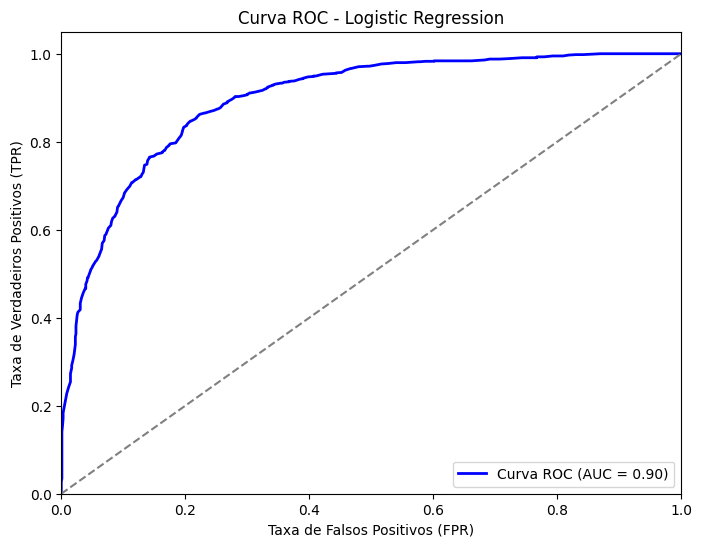

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Instanciando o modelo
model = LogisticRegression(max_iter=1000)

# Treinando o modelo com os dados de treino
model.fit(X_train, y_train)

# Fazendo previsões
y_pred_rf = model.predict(X_test)
y_prob_rf = model.predict_proba(X_test)[:, 1]  # Pega as probabilidades da classe 1

# Fazendo previsões com os dados de teste
y_pred = model.predict(X_test)

# Exibindo a acurácia
print(f'Acurácia do modelo: {accuracy_score(y_test, y_pred)}')

# Exibindo o relatório de classificação (precisão, recall, F1-score)
print(classification_report(y_test, y_pred))

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='b', lw=2, label=f'Curva ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência (caso aleatório)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

##### Modelo Support Vector Machine

Acurácia do modelo: 0.83
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1013
           1       0.84      0.81      0.82       987

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



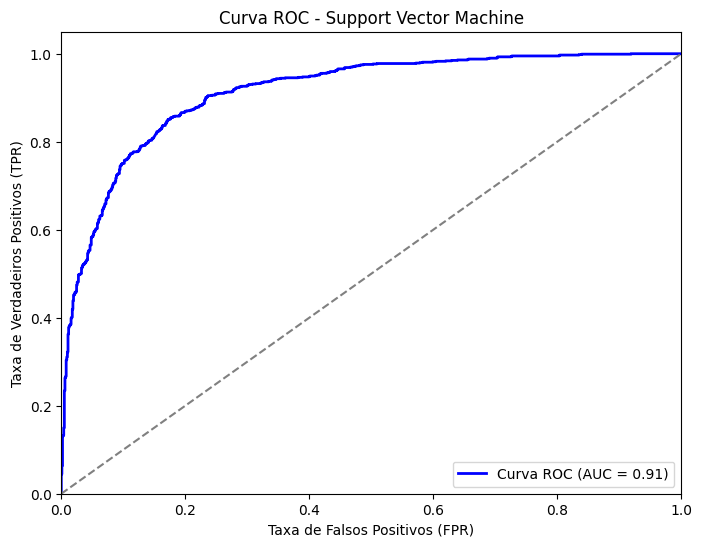

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Criação do modelo SVM com parâmetros padrão
svm = SVC(random_state=42, probability=True)

# Treinamento do modelo com os dados de treinamento
svm.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = svm.predict(X_test)

# Fazendo previsões
y_pred_rf = svm.predict(X_test)
y_prob_rf = svm.predict_proba(X_test)[:, 1]  # Pega as probabilidades da classe 1

# Avaliação do modelo
print(f"Acurácia do modelo: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Calculando a curva ROC e AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='b', lw=2, label=f'Curva ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência (caso aleatório)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Support Vector Machine')
plt.legend(loc='lower right')
plt.show()

##### Modelo XGBoost

Acurácia do modelo: 0.8165
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1013
           1       0.82      0.81      0.81       987

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



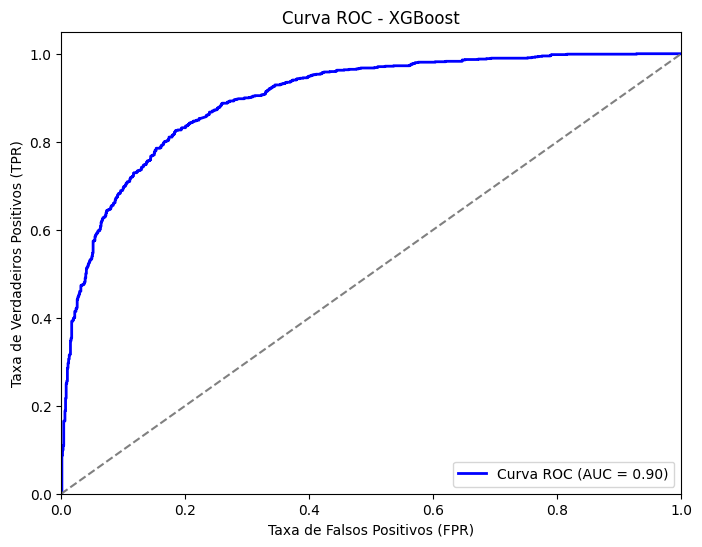

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Criando o modelo XGBoost
xgb = XGBClassifier(
    n_estimators=200,      # Número de árvores
    learning_rate=0.1,     # Taxa de aprendizado
    max_depth=6,           # Profundidade máxima da árvore
    subsample=0.8,         # Porcentagem de amostras usadas por árvore
    colsample_bytree=0.8,  # Porcentagem de features usadas por árvore
    eval_metric='logloss'  # Evita warnings sobre métricas
)

# Treinando o modelo
xgb.fit(X_train, y_train)


# Fazendo previsões
y_pred_rf = xgb.predict(X_test)
y_prob_rf = xgb.predict_proba(X_test)[:, 1]  # Pega as probabilidades da classe 1

# Fazendo previsões
y_pred = xgb.predict(X_test)

# Avaliando o modelo
print("Acurácia do modelo:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculando a curva ROC e AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='b', lw=2, label=f'Curva ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência (caso aleatório)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend(loc='lower right')
plt.show()

##### Modelo Random Forest

Acurácia do modelo: 0.8105
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1013
           1       0.80      0.81      0.81       987

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



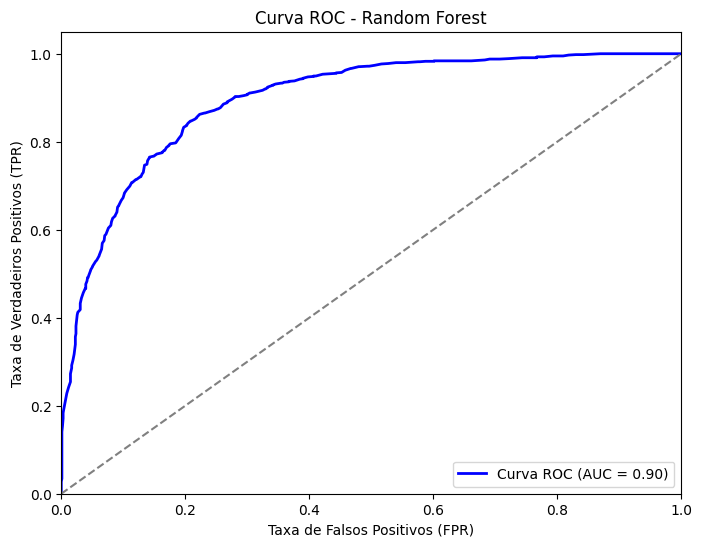

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Criando e treinando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Fazendo previsões
y_pred_rf = rf.predict(X_test)

# Fazendo previsões
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # Pega as probabilidades da classe 1

# Avaliando o modelo
print("Acurácia do modelo: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print(classification_report(y_test, y_pred_rf))

# Calculando a curva ROC e AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='b', lw=2, label=f'Curva ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência (caso aleatório)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

#### Resultados
Neste trabalho, foi realizada uma análise de sentimentos em resenhas de produtos da Amazon, utilizando diferentes modelos de machine learning para prever a polaridade das avaliações (positiva ou negativa). Para isso, utilizamos quatro algoritmos principais: Regressão Logística, SVM (Máquina de Vetores de Suporte), XGBoost e Random Forest, comparando suas performances por meio de métricas de avaliação como Acurácia, Precision, Recall, F1-Score e AUC (Área sob a Curva ROC).

Resultados dos Modelos
Regressão Logística:

Acurácia: 0.836

AUC: 0.90

A Regressão Logística obteve o melhor desempenho em termos de Acurácia entre os modelos avaliados. Embora tenha apresentado uma AUC de 0.90 (similar à Random Forest e XGBoost), sua capacidade de fazer previsões corretas foi ligeiramente superior, atingindo 83.6% de acerto.
SVM (Máquina de Vetores de Suporte):

Acurácia: 0.

AUC: 0.91

O SVM apresentou a melhor AUC, com 0.91, indicando uma excelente capacidade de discriminação entre as classes. No entanto, sua Acurácia foi um pouco inferior à da Regressão Logística, com 83%. Mesmo assim, o SVM demonstrou bom desempenho em termos de Precision e Recall, sendo uma escolha robusta para este tipo de problema.
XGBoost:

Acurácia: 0.8165

AUC: 0.90

O modelo XGBoost teve uma Acurácia de 81.65%, ligeiramente inferior à da Regressão Logística. A AUC também foi de 0.90, indicando que o modelo tem um bom poder de discriminação entre as classes, embora não tenha superado o SVM em AUC.
Random Forest:

Acurácia: 0.8105

AUC: 0.90

A Random Forest teve uma Acurácia de 81.05%, ficando abaixo da Regressão Logística. No entanto, a AUC também foi de 0.90, indicando que a capacidade de distinguir entre as classes foi razoavelmente boa. O desempenho da Random Forest foi sólido, mas não foi capaz de superar os outros modelos em termos de acurácia ou AUC.

#### Conclusões
Com base nos resultados obtidos, com os parâmetros escolhidos, podemos observar que:

O modelo de Regressão Logística apresentou o melhor desempenho geral em termos de acurácia, atingindo 83.6%, seguido pelo SVM, que teve a melhor AUC (0.91) e uma boa precisão e recall.
O SVM mostrou-se bastante eficaz em termos de discriminação entre as classes, mas teve uma leve perda em Acurácia comparado à Regressão Logística.

O XGBoost e a Random Forest também apresentaram resultados bastante sólidos, com Acurácias ao redor de 81% e boas AUCs de 0.90, mas não foram tão eficazes quanto os outros dois modelos.